In [182]:
# -------------------------------------------------------------------------------------------------------------------
# Course name - Exploratory data analysis
# Course code - DSC530
# Week 3 assignment
# Script name - Shekhar530Week3.ipynb
# Creator - Manish Shekhar
# Date created - Dec 12th to Dec 15th
# -------------------------------------------------------------------------------------------------------------------

### Page 11 1-1 & 1-2 Reading, and cleaning the NSFG respondent and pregnancy data file

In [175]:
# [Manish] - Importing required libraries

import sys
import numpy as np
import thinkstats2
import matplotlib.pyplot as plt
import math
import statistics

from collections import defaultdict



# [Manish] - Reading the data file (NSFG repondent data) and cleaning it
dct_file='/Users/mshekhar/Downloads/2002FemResp.dct'
dat_file='/Users/mshekhar/Downloads/2002FemResp.dat.gz'
dct = thinkstats2.ReadStataDct(dct_file)
df_resp = dct.ReadFixedWidth(dat_file, compression='gzip', nrows=None)


# [Manish] - Reading the data file (NSFG pregnancy data)
dct_file='/Users/mshekhar/Downloads/2002FemPreg.dct'
dat_file='/Users/mshekhar/Downloads/2002FemPreg.dat.gz'
dct = thinkstats2.ReadStataDct(dct_file)
df_preg = dct.ReadFixedWidth(dat_file, compression='gzip')


# [Manish] - User defined function to clean the pregnancy data 
def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.
    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0

    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)

    df.babysex.replace([7, 9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)

    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0    

    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.cmintvw = np.nan
    
    

# [Manish]- cleaning the data in pregnancy file
CleanFemPreg(df_preg)

In [38]:
# check number of records and columns in pregnancy data frame
df_preg.shape
# Total 13,593 rows and 244 columns

(13593, 244)

In [21]:
# Considering Pregnancy data file to summarize if first pregnancy is delayed.
# check columns in the pregnancy data set 
df_preg.columns

Index(['caseid', 'pregordr', 'howpreg_n', 'howpreg_p', 'moscurrp', 'nowprgdk',
       'pregend1', 'pregend2', 'nbrnaliv', 'multbrth',
       ...
       'laborfor_i', 'religion_i', 'metro_i', 'basewgt', 'adj_mod_basewgt',
       'finalwgt', 'secu_p', 'sest', 'cmintvw', 'totalwgt_lb'],
      dtype='object', length=244)

In [101]:
# checking distinct values in outcome (pregnancy outcome)
df_preg['outcome'].value_counts()

1    9148
4    1921
2    1862
6     352
5     190
3     120
Name: outcome, dtype: int64

In [102]:
# checking unique values outcome (pregnancy outcome) as value counts skips na
df_preg['outcome'].unique()

array([1, 2, 4, 5, 3, 6])

In [181]:
# checking stats
df_preg['outcome'].value_counts()
# About 3/4th of the pregnancies has live birth in the data file at hand

1    9148
4    1921
2    1862
6     352
5     190
3     120
Name: outcome, dtype: int64

In [105]:
# creating a data filter with live births as we are conserned with finding about first pregnancy tenure
filter_live_preg = df_preg['outcome']==1
filter_live_preg.value_counts()

True     9148
False    4445
Name: outcome, dtype: int64

In [106]:
# create a data frame with live births only
df_live_preg = df_preg[filter_live_preg]
df_live_preg['outcome'].value_counts()
# all pregnancies with outcome != 1 (live birth) are filtered out

1    9148
Name: outcome, dtype: int64

In [113]:
# checking distinct data in birthord (order of pregnancy for live births i.e. is it first, last etc)
df_preg['birthord'].value_counts()
# As we are only concerned with checking if first live births were delayed, we need to create two data frames 
# 1. first live pregnancies
# 2. all other (second to last) live pregnancies
# And then compare their distributions & summary stats


1.0     4413
2.0     2874
3.0     1234
4.0      421
5.0      126
6.0       50
7.0       20
8.0        7
9.0        2
10.0       1
Name: birthord, dtype: int64

In [114]:
# creating the data two data frames 
# 1. first live pregnancies
# 2. all other (second to last) live pregnancies
filter_first_live_preg = df_live_preg['birthord']==1
df_first_live_preg = df_live_preg[filter_first_live_preg]
df_all_other_live_preg = df_live_preg[~filter_first_live_preg]

## Page 25 2-1 : Based on learning in chapter summarize if first babies arrive late

In [151]:
# check live pregnancy data frame
df_live_preg.columns
df_live_preg['prglngth'].describe()
# We can see some summary stats i.e. mean, standard deviation, different percentiles etc
# Mean or average of live pregnancies is 38.56 weeks

count    9148.000000
mean       38.560560
std         2.702344
min         0.000000
25%        39.000000
50%        39.000000
75%        39.000000
max        50.000000
Name: prglngth, dtype: float64

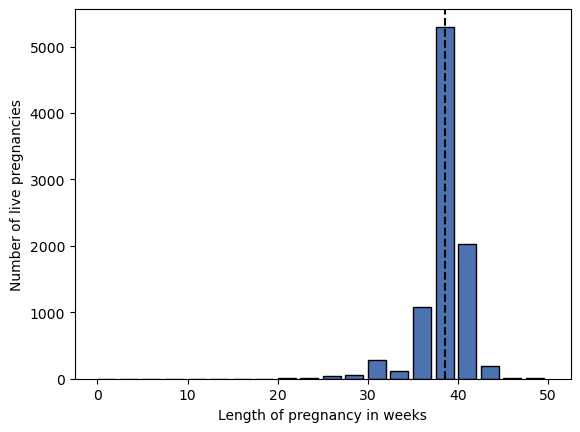

In [178]:
# plot the histogram with of pregnancy length for live births
plt.style.use('seaborn-deep')
plt.hist(np.array(df_live_preg['prglngth']), width = 2, edgecolor = "black", bins=20)

# Label the axes
plt.xlabel('Length of pregnancy in weeks')
plt.ylabel('Number of live pregnancies')

m = statistics.mean(df_live_preg['prglngth'])
plt.axvline(m, color='k', linestyle='dashed')

# Show the figure
plt.show()

# Any pregnancy above 45 weeks seems like outlier
# Any pregnancy below 23 weeks seems like outlier
# Data is long tailed to left which shows premature births between 30 to 38 weeks

In [149]:
# check first live pregnancy data frame
df_first_live_preg.columns
df_first_live_preg['prglngth'].describe()
# We can see some summary stats i.e. mean, standard deviation, different percentiles etc
# Mean or average of first live pregnancies is 38.6 weeks

count    4413.000000
mean       38.600952
std         2.791901
min         0.000000
25%        39.000000
50%        39.000000
75%        40.000000
max        48.000000
Name: prglngth, dtype: float64

In [150]:
# check all other first live pregnancy data frame
df_all_other_live_preg.columns
df_all_other_live_preg['prglngth'].describe()
# We can see some summary stats i.e. mean, standard deviation, different percentiles etc
# Mean or average of first live pregnancies is 38.52 weeks

count    4735.000000
mean       38.522914
std         2.615852
min         4.000000
25%        39.000000
50%        39.000000
75%        39.000000
max        50.000000
Name: prglngth, dtype: float64

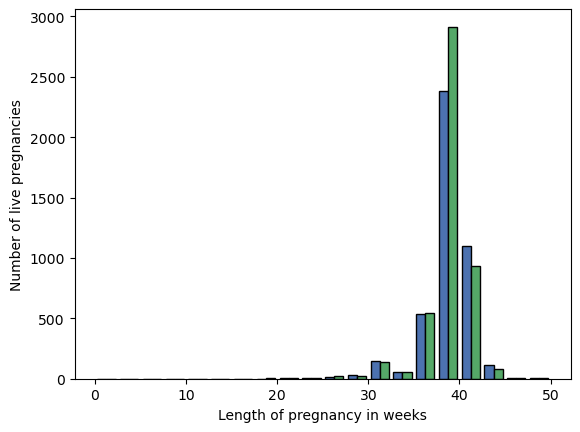

In [142]:
# plot the side by side histograms of two groups - first, live birth vs all other live birth
plt.style.use('seaborn-deep')
x = np.array(df_first_live_preg['prglngth'])
y = np.array(df_all_other_live_preg['prglngth'])

plt.hist([x, y], bins=20, edgecolor = "black", label=['first', 'other'])

plt.xlabel('Length of pregnancy in weeks')
plt.ylabel('Number of live pregnancies')


# Show the figure
plt.show()


# OBSERVATION 
# -------------------
# As Allen Downey has suggested in the book, because we have fever observations of first live birth 
# than other live births this comparison wouldn't be correct. We need to check other reliable ways to compare 
# these groups. 

In [158]:
# Allen suggests that better way to compare the two groups or samples of data at hand 
# will be to look at (difference in their means by variability in the groups) which is also called Cohen's D

# User defined function to calculate Cohen's D as Allen provided in the book
def CohenEffectSize(group1, group2):
    diff = group1.mean() - group2.mean()

    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / math.sqrt(pooled_var)
    return d


CohenEffectSize(df_first_live_preg['prglngth'], df_all_other_live_preg['prglngth'])



0.028879044654449883

In [159]:
# OBSERVATION
# ------------------
# Cohen's D is too small and thus there is no significant difference that can be reported.
# Difference in mean is also small which is 0.078 weeks which is about 13 hours. 
# With difference so small statistically it is difficult to say that obviously first live births are delayed.
# I would collect more data or try resampling and also other ways of more accurate comparisons 
# i.e. cdfs (cummulative distribution function)

## Page 25 2-4 : Investigate using totalwgt_lb of first babies are lighter or heavier

In [161]:
# Check summary stats of totalwgt_lb in first live pregnancy data frame
df_first_live_preg['totalwgt_lb'].describe()
# We can see some summary stats i.e. mean, standard deviation, different percentiles etc
# Mean or average of baby's total weight in case of first live pregnancies is 7.20 pounds

count    4363.000000
mean        7.201094
std         1.420573
min         0.125000
25%         6.437500
50%         7.312500
75%         8.000000
max        15.437500
Name: totalwgt_lb, dtype: float64

In [164]:
# Check summary stats of totalwgt_lb in all other live pregnancy data frame
df_all_other_live_preg['totalwgt_lb'].describe()
# We can see some summary stats i.e. mean, standard deviation, different percentiles etc
# Mean or average of baby's total weight in case of all other live pregnancies is 7.32 pounds

count    4675.000000
mean        7.325856
std         1.394195
min         0.562500
25%         6.500000
50%         7.375000
75%         8.187500
max        14.000000
Name: totalwgt_lb, dtype: float64

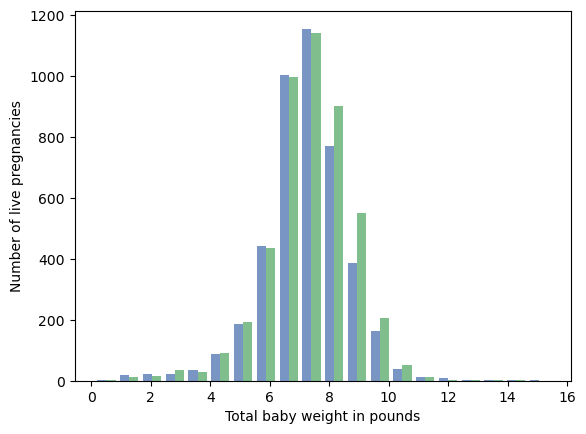

In [179]:
# plot the side by side histograms of two groups - baby's total weight in first live birth vs in all other live birth
plt.style.use('seaborn-deep')
x = np.array(df_first_live_preg['totalwgt_lb'])
y = np.array(df_all_other_live_preg['totalwgt_lb'])

plt.hist([x, y], bins=20, label=['first', 'other'], alpha = 0.75)

plt.xlabel('Total baby weight in pounds')
plt.ylabel('Number of live pregnancies')


# Trying to plot means on the histogram, does not seems to be working :(
m1 = statistics.mean(df_first_live_preg['totalwgt_lb'])
m2 = statistics.mean(df_all_other_live_preg['totalwgt_lb'])
plt.axvline(m1, color='k', linestyle='dashed')
plt.axvline(m2, color='y', linestyle='dashed')


# Show the figure
plt.show()


# OBSERVATION 
# -------------------
# As Allen Downey has suggested in the book, because we have fever observations of first live birth 
# than all other live births this comparison wouldn't be correct. We need to check other reliable ways to compare 
# these groups. 
# Mean of baby's total weight in first live birth is 0.12 pounds or 1.92 ounces lesser than those who are 
# not first borns. This is not significant enough.

In [168]:
# Allen suggests that better way to compare the two groups or samples of data at hand 
# will be to look at (difference in their means by variability in the groups) which is also called Cohen's D

# User defined function to calculate Cohen's D as Allen provided in the book
def CohenEffectSize(group1, group2):
    diff = group1.mean() - group2.mean()

    var1 = group1.var()
    var2 = group2.var()
    n1, n2 = len(group1), len(group2)

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / math.sqrt(pooled_var)
    return d


CohenEffectSize(df_first_live_preg['totalwgt_lb'], df_all_other_live_preg['totalwgt_lb'])


-0.088672927072602

In [ ]:
# OBSERVATION
# ------------------
# Cohen's D of 0.088 standard deviation is too small and thus there is no significant difference that can be reported.
# Difference in means is also small which is 0.12 pounds or 1.92 ounces. 
# With difference so small statistically it is difficult to say that obviously baby's total weight in 
# first live births will always be lesser than those who are not first borns.
# I would collect more data or try resampling and also other ways of more accurate comparisons 
# i.e. cdfs (cummulative distribution function)